# 0.2 Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
# Print first 5 samples of our dataset
for data, label in zip(X[:5], y[:5]):
    print(f"data: {data}, label: {label}")

data: [0.75424625 0.23148074], label: 1
data: [-0.75615888  0.15325888], label: 1
data: [-0.81539193  0.17328203], label: 1
data: [-0.39373073  0.69288277], label: 1
data: [ 0.44220765 -0.89672343], label: 0


In [4]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

print(circles.head())

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0


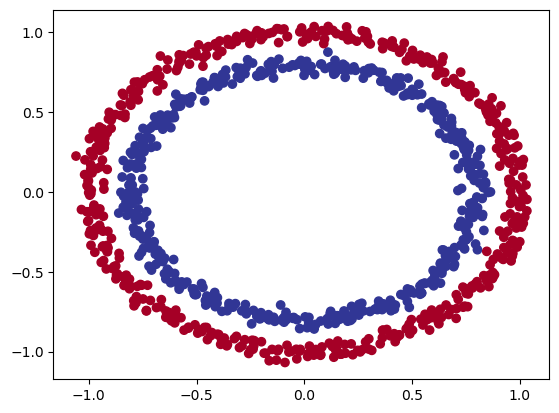

In [5]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape}, and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,), and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Print first 5 samples of our dataset
for data, label in zip(X[:5], y[:5]):
    print(f"data: {data}, label: {label}")

data: tensor([0.7542, 0.2315]), label: 1.0
data: tensor([-0.7562,  0.1533]), label: 1.0
data: tensor([-0.8154,  0.1733]), label: 1.0
data: tensor([-0.3937,  0.6929]), label: 1.0
data: tensor([ 0.4422, -0.8967]), label: 0.0


In [10]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [11]:
# Split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [13]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
# Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # Define forward method() that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
# Instantiate an instance of our model class and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# Let's replicate model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6997,  0.6732],
                      [ 0.3436, -0.0518],
                      [ 0.0477,  0.5998],
                      [-0.4070,  0.1196],
                      [ 0.3362, -0.4886]])),
             ('0.bias', tensor([-0.6141, -0.2328,  0.0184, -0.0212, -0.5340])),
             ('1.weight',
              tensor([[-0.0576, -0.2997, -0.0661,  0.1740,  0.3116]])),
             ('1.bias', tensor([0.2087]))])

In [17]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions :\n{torch.round(untrained_preds)[:10]}")
print(f"\nFirst 10 labels :\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions :
tensor([[0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]])

First 10 labels :
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [18]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in (withLogitsLoss)

# same as above
# loss_fn = nn.Sequential(
#             nn.Sigmoid(),
#             nn.BCELoss()
#         )

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [19]:
# Calculate accuracy - out of hundred examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model
To train our model, we are going to need to build a training loop with the follawing steps:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs will be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multi class classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [20]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():    
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0521],
        [-0.0457],
        [ 0.2828],
        [-0.0131],
        [ 0.2418]])

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [22]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5130],
        [0.4886],
        [0.5702],
        [0.4967],
        [0.5602]])

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5,  `y=0` (class 0)

In [23]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


### 3.2 Building a training loop and testing loop

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss / accuracy
    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss / acc
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69963, Acc: 54.37% | Test loss: 0.69243, Test acc: 54.50%
Epoch: 10 | Loss: 0.69647, Acc: 51.62% | Test loss: 0.69119, Test acc: 53.50%
Epoch: 20 | Loss: 0.69510, Acc: 50.25% | Test loss: 0.69108, Test acc: 54.50%
Epoch: 30 | Loss: 0.69441, Acc: 49.38% | Test loss: 0.69130, Test acc: 54.50%
Epoch: 40 | Loss: 0.69401, Acc: 49.50% | Test loss: 0.69161, Test acc: 53.50%
Epoch: 50 | Loss: 0.69375, Acc: 48.75% | Test loss: 0.69191, Test acc: 52.50%
Epoch: 60 | Loss: 0.69356, Acc: 49.00% | Test loss: 0.69219, Test acc: 53.50%
Epoch: 70 | Loss: 0.69342, Acc: 48.12% | Test loss: 0.69245, Test acc: 52.50%
Epoch: 80 | Loss: 0.69332, Acc: 48.50% | Test loss: 0.69269, Test acc: 51.50%
Epoch: 90 | Loss: 0.69324, Acc: 48.12% | Test loss: 0.69290, Test acc: 51.50%


# 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

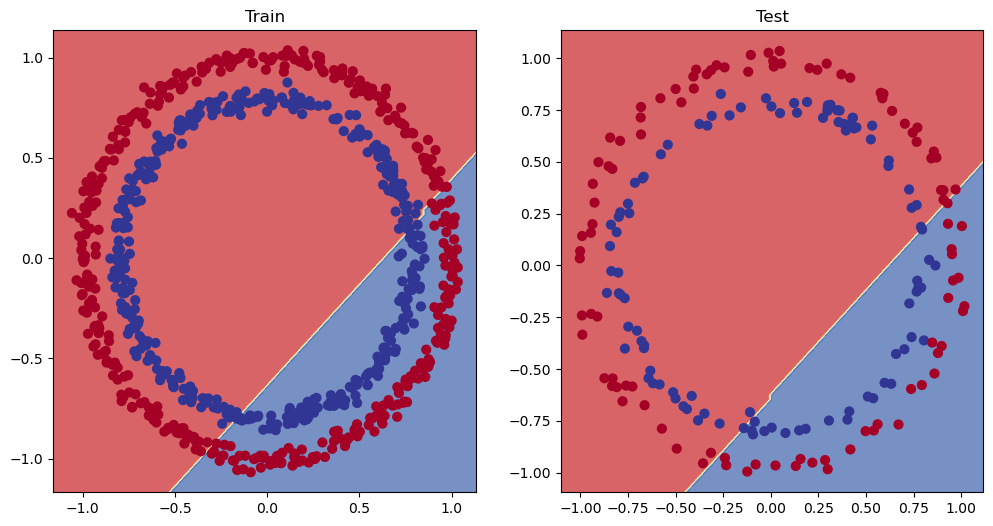

In [25]:
from helper_functions import plot_decision_boundary, plot_predictions

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options all from model's perspective because they deal directly with the model, rather than the data.

And because this options are all values we (as mle and data scientists) can change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [26]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [28]:
# Write a training and eval loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss / accuracy
    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss / acc
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.69369, Acc: 50.25% | Test loss: 0.69270, Test acc: 50.00%
Epoch: 20 | Loss: 0.69351, Acc: 50.12% | Test loss: 0.69283, Test acc: 49.50%
Epoch: 30 | Loss: 0.69339, Acc: 50.50% | Test loss: 0.69297, Test acc: 48.00%
Epoch: 40 | Loss: 0.69329, Acc: 50.38% | Test loss: 0.69310, Test acc: 49.00%
Epoch: 50 | Loss: 0.69322, Acc: 49.88% | Test loss: 0.69324, Test acc: 50.00%
Epoch: 60 | Loss: 0.69317, Acc: 49.38% | Test loss: 0.69336, Test acc: 51.50%
Epoch: 70 | Loss: 0.69312, Acc: 49.38% | Test loss: 0.69348, Test acc: 50.50%
Epoch: 80 | Loss: 0.69309, Acc: 50.12% | Test loss: 0.69359, Test acc: 50.00%
Epoch: 90 | Loss: 0.69307, Acc: 50.50% | Test loss: 0.69370, Test acc: 48.50%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 110 | Loss: 0.69303, Acc: 50.88% | Test loss: 0.69388, Test acc: 46.50%
Epoch: 120 | Loss: 0.69302, Acc: 50.75% | Test loss: 0.69396, T

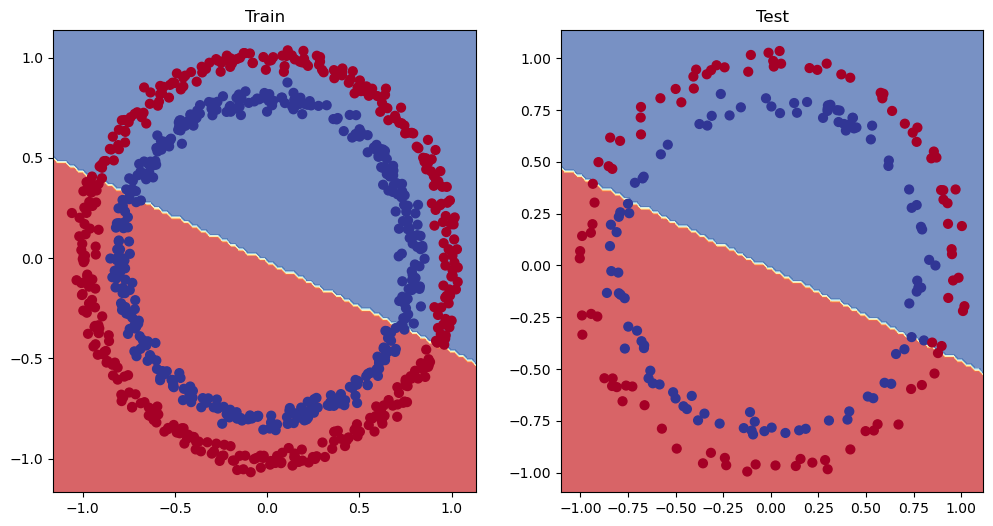

In [29]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [30]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [31]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lenghts of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

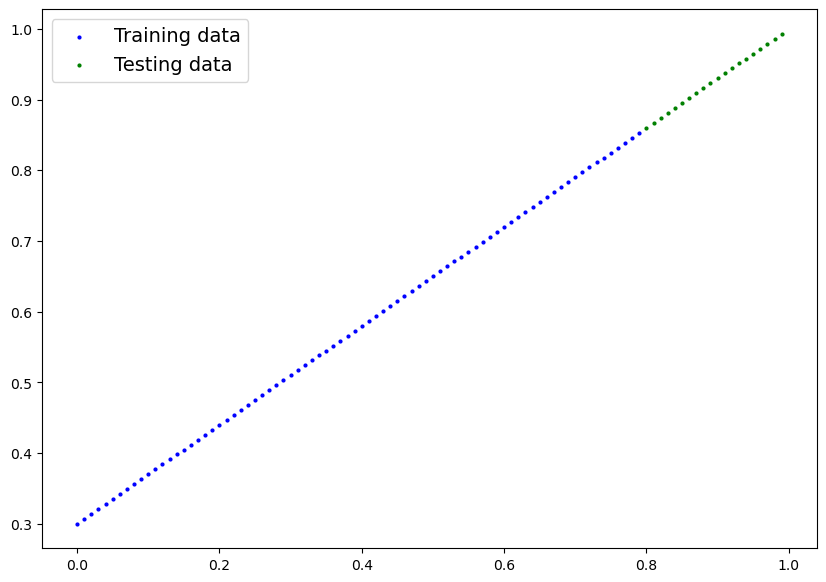

In [32]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### 5.2 Adjusting `model_1` to fit a straight line

In [33]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [35]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# number of epochs
epochs = 2000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        # Printout what's happenin'
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360
Epoch: 1000 | Loss: 0.01782 | Test loss: 0.00333
Epoch: 1100 | Loss: 0.01674 | Test loss: 0.00317
Epoch: 1200 | Loss: 0.01640 | Test loss: 0.00316
Epoch: 1300 | Loss: 0.01648 | Test loss: 0.00256
Epoch: 1400 | Loss: 0.01648 | Test loss: 0.00323
Epoch: 1500 | Loss: 0.01632 | Test loss: 0.00337
Epoch: 1600 | Loss: 0.01596 | Test loss: 0.00284
Epoch: 1700 | Loss: 0.01458 | Test loss: 0.00244
Epoch: 1800 | Loss: 0.01532 | Test loss: 0.00275
Epoch: 1900 | Loss: 0.01406 | Test loss: 0.00288


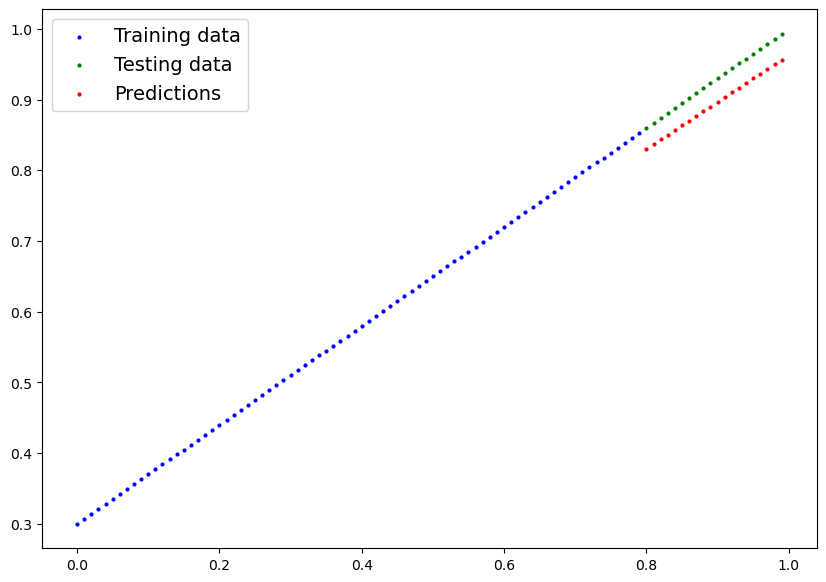

In [36]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear or non-linear functions?




### 6.1 Recreating non-linear data (red and blue circles)

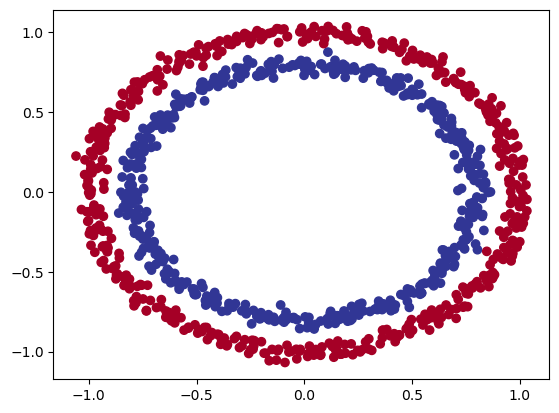

In [37]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [38]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which potentially able to find patterns in data.

In [39]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [40]:
# Setup loss and optimizers
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [41]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 2000

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818, Acc: 87.75% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153, Acc: 93.50% | Test loss: 0.49935, Test acc: 90.50%
Epoch: 1200 | Loss: 0.37056, Acc: 97.75% | Test loss

### Evaluating a model trained with non-linear activation functions

In [42]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

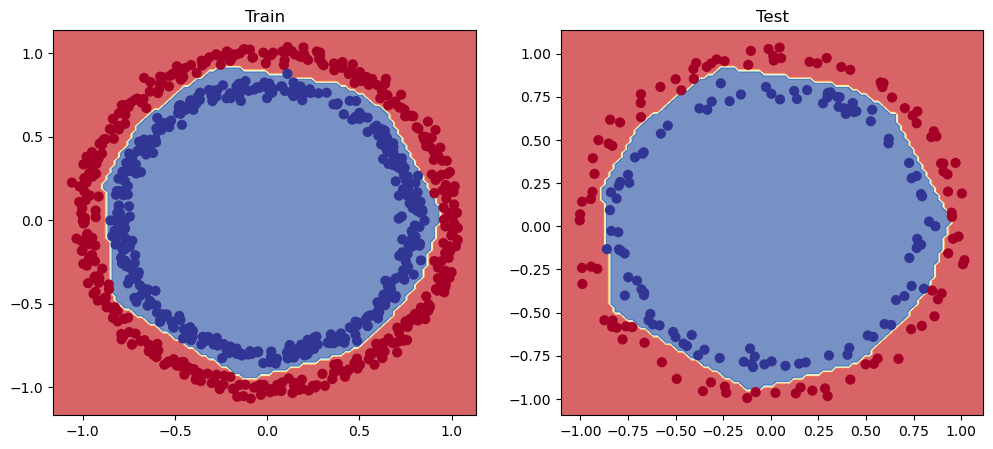

In [43]:
# Plot decision boundaries
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions
Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [44]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A, A.dtype, A.shape

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 torch.float32,
 torch.Size([20]))

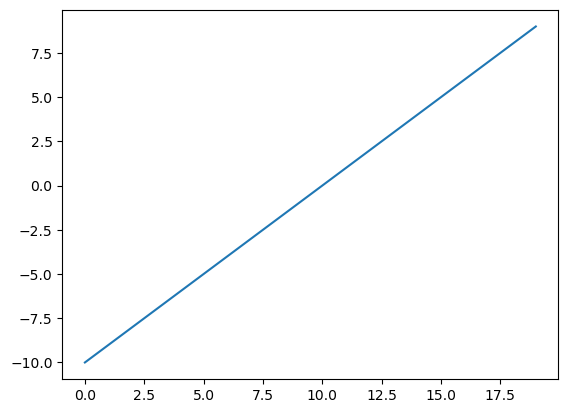

In [45]:
# Visualize the tensor
plt.plot(A);

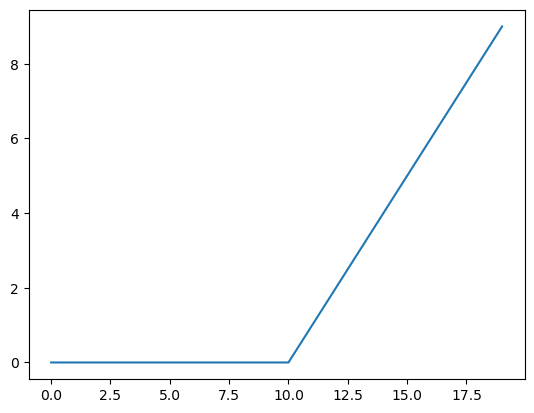

In [46]:
plt.plot(torch.relu(A));

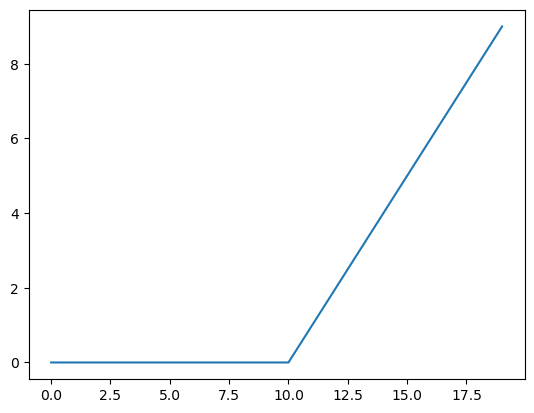

In [47]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # input must be tensors

plt.plot(relu(A));

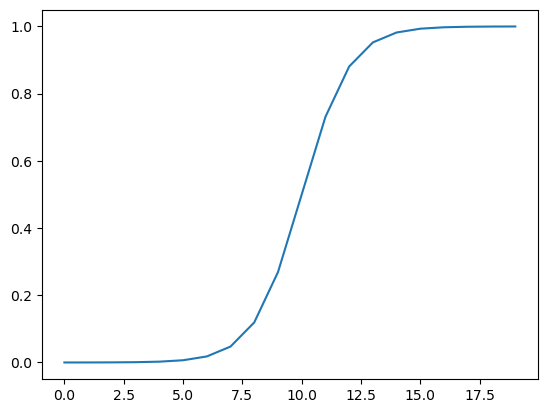

In [48]:
plt.plot(torch.sigmoid(A));

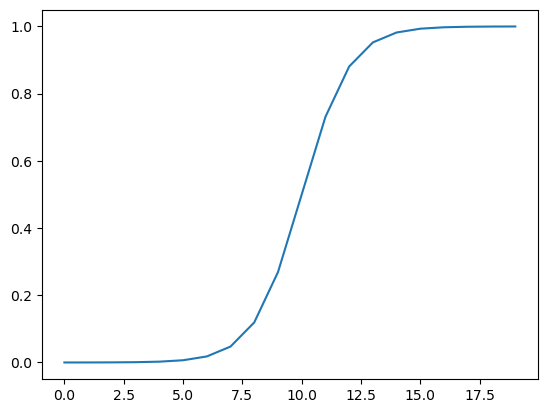

In [49]:
# sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classficiation problem
* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

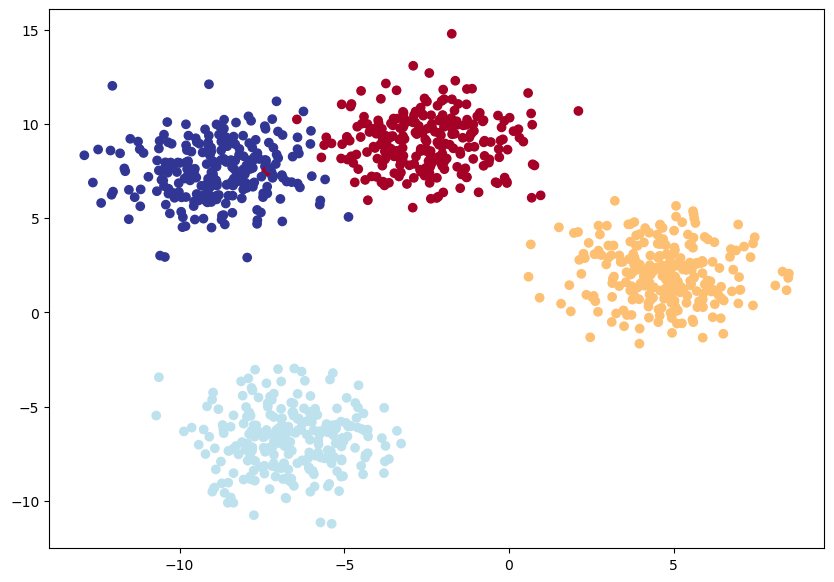

In [50]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the cluster a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot the data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show();

### 8.2 Building a multi-class classification model in PyTorch

In [51]:
# Setup device-agnostic code - mps is for Apple Silicon
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: mps


In [52]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes multi-class classification model.

        Args:
            input_features (int): size of the input features
            output_features (int): size of the output features
            hidden_units (int): size of the hidden units

        Returns:
            None

        Example usage:
            >>> model = BlobModel(input_features=2,
                                  output_features=4,
                                  hidden_units=8)
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classficiation model

In [53]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = torch.nn.CrossEntropyLoss()

# Create an optimizer - optimizer update our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probobilities for multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [54]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:5]

/Users/alp/miniconda3/envs/torch/lib/python3.9/site-packages/torch/_tensor_str.py:125: UserWarning: 1MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1676448526786/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1260.)
  nonzero_finite_min = tensor_totype(nonzero_finite_abs.min())


tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='mps:0')

In [55]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [56]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='mps:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='mps:0')


In [57]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([1, 0, 0, 0, 0], device='mps:0')

In [58]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [59]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
    ### Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test loss: {test_loss} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588 | Acc: 40.38% | Test loss: 1.0755419731140137 | Test acc: 48.00%
Epoch: 10 | Loss: 0.6448 | Acc: 96.75% | Test loss: 0.6606872081756592 | Test acc: 97.50%
Epoch: 20 | Loss: 0.4254 | Acc: 98.50% | Test loss: 0.43074116110801697 | Test acc: 100.00%
Epoch: 30 | Loss: 0.2529 | Acc: 99.12% | Test loss: 0.2450762540102005 | Test acc: 99.50%
Epoch: 40 | Loss: 0.1123 | Acc: 99.25% | Test loss: 0.10228519141674042 | Test acc: 99.50%
Epoch: 50 | Loss: 0.0663 | Acc: 99.25% | Test loss: 0.058475375175476074 | Test acc: 99.50%
Epoch: 60 | Loss: 0.0507 | Acc: 99.25% | Test loss: 0.042932260781526566 | Test acc: 99.50%
Epoch: 70 | Loss: 0.0430 | Acc: 99.25% | Test loss: 0.03490963578224182 | Test acc: 99.50%
Epoch: 80 | Loss: 0.0384 | Acc: 99.25% | Test loss: 0.02987818792462349 | Test acc: 99.50%
Epoch: 90 | Loss: 0.0352 | Acc: 99.25% | Test loss: 0.02662649191915989 | Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [60]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the fist 10 predictions
y_logits[:10]  

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1737, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9465],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3762, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='mps:0')

In [61]:
# Go from Logits to Prediction Probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3437e-03, 9.9865e-01, 1.2163e-06, 5.3854e-07],
        [4.9905e-03, 7.4739e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6059e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1955e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4903e-06, 2.2377e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7988e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5043e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]], device='mps:0')

In [62]:
# Go from Prediction Probabilities to Prediction Labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0'))

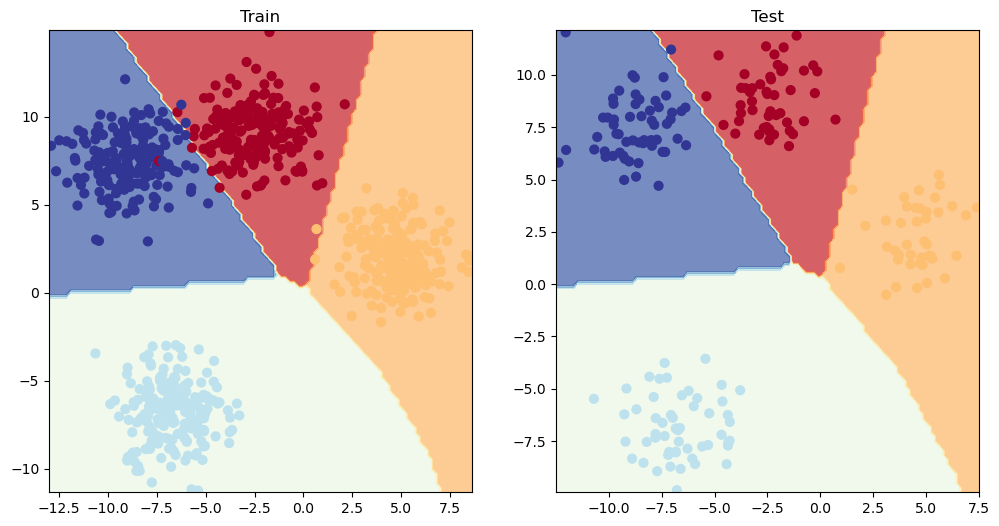

In [63]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of hundred samples how many does our model right?
* Precision - 
* Recall - 
* F1-score - 
* Confusion matrix -
* Classification report - 

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

In [66]:
from torchmetrics import Accuracy

# Setup metrics
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='mps:0')